## Data Analysis and Science: US Accidents (2016-2023)
 
#### This notebook aims to perform a comprehensive and exploratory analysis of accidents in the USA from 2016 to 2023.

## Objectives

- Explore the trends and patterns in traffic accidents during the specified period.
- Identify the factors contributing to the occurrence and severity of accidents.
- Build predictive models to forecast accident severity based on various characteristics.


#### Acknowledgements

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. <a href="https://arxiv.org/abs/1906.05409"> “A Countrywide Traffic Accident Dataset.”</a>, 2019.

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. <a href="https://arxiv.org/abs/1909.09638">"Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights."</a> In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
!pip install us xgboost

In [7]:
import folium
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import us
from folium.plugins import HeatMap, MarkerCluster
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [8]:
# Reading the dataset

df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


## Exploratory Data Analysis and Handling of Null Values

In [9]:
df.dtypes

ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump      

In [10]:
df.isnull().sum()

ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  220377
End_Lng                  220377
Distance(mi)                  0
Description                   1
Street                      691
City                         19
County                        0
State                         0
Zipcode                     116
Country                       0
Timezone                    507
Airport_Code               1446
Weather_Timestamp          7674
Temperature(F)            10466
Wind_Chill(F)            129017
Humidity(%)               11130
Pressure(in)               8928
Visibility(mi)            11291
Wind_Direction            11197
Wind_Speed(mph)           36987
Precipitation(in)        142616
Weather_Condition         11101
Amenity                       0
Bump                          0
Crossing

In [11]:
# Excluding columns that will not be necessary for analysis

drop = [
    'End_Lat',
    'End_Lng',
    'Distance(mi)',
    'Street',
    'County',
    'Zipcode',
    'Timezone',
    'Airport_Code',
    'Weather_Timestamp',
    'Visibility(mi)',
    'Wind_Direction',
    'Wind_Speed(mph)',
    'Precipitation(in)',
    'Weather_Condition',
    'Sunrise_Sunset',
    'Civil_Twilight',
    'Nautical_Twilight',
    'Astronomical_Twilight',
    'Temperature(F)',
    'Wind_Chill(F)',
    'Humidity(%)',
    'Pressure(in)'
]

df = df.drop(drop, axis=1)

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,False,True,False
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,False
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,False,True,False
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,False
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,False


In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

ID                 0
Source             0
Severity           0
Start_Time         0
End_Time           0
Start_Lat          0
Start_Lng          0
Description        0
City               0
State              0
Country            0
Amenity            0
Bump               0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
dtype: int64

In [14]:
df.head(2)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,False,True,False
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,False


In [15]:
#Viewing the number of accidents per severity level

df['Severity'].value_counts()

Severity
2    398126
3     84518
4     13062
1      4274
Name: count, dtype: int64

### Function to retrieve the full name of each state in English from its abbreviation and saving it into a new dataframe.

In [16]:
def get_state_name(abbreviation):
    if abbreviation is not None:
        state_obj = us.states.lookup(abbreviation)
        return state_obj.name if state_obj is not None else None
    else:
        return None

df['State_Name'] = df['State'].apply(get_state_name)

df.to_csv('US_Accidents_Updated.csv', index=False)

df


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,True,False,Louisiana
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,Virginia
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,True,False,California
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,Minnesota
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,A-6077227,Source1,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,Stationary traffic on OR-47 from NW Martin Rd ...,Forest Grove,OR,...,False,False,False,False,False,False,False,False,False,Oregon
499996,A-6323243,Source1,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,Incident on MILITARY TRL near WESTGATE AVE Dri...,West Palm Beach,FL,...,False,False,False,False,False,False,False,False,False,Florida
499997,A-3789256,Source1,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,Crash on the right shoulder on E SR-69 Northbo...,Dewey,AZ,...,False,False,False,False,False,False,False,True,False,Arizona
499998,A-7030381,Source1,3,2020-05-15 17:20:56,2020-05-15 17:50:56,38.406680,-78.619310,At US-340/S Stuart Ave - Serious accident.,Elkton,VA,...,False,False,False,False,False,False,False,True,False,Virginia


### Working on the updated dataframe

In [17]:
df_updated = pd.read_csv('US_Accidents_Updated.csv')
df_updated.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,False,True,False,Louisiana
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,False,Virginia
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,False,True,False,California
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,False,Minnesota
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,False,California


### Question 1: How many accidents per year and per month, and can we draw any conclusions from this?

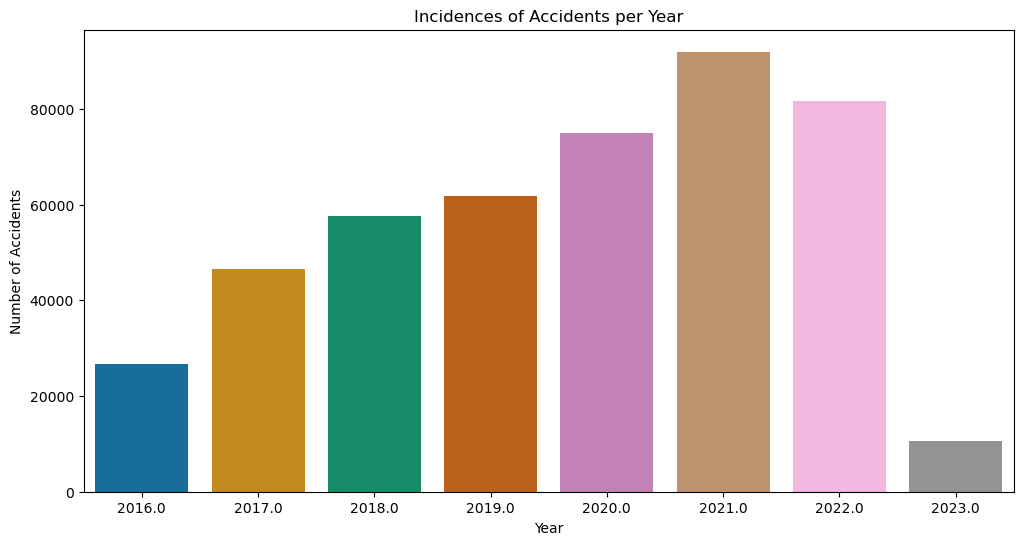

In [18]:
# Catching the accidents per year and plotting it into a graph

df_copy_date = df_updated.copy()

df_copy_date['Start_Time'] = pd.to_datetime(df_copy_date['Start_Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

df_copy_date['Year'] = df_copy_date['Start_Time'].dt.year

yearly_counts = df_copy_date['Year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='colorblind')
plt.title('Incidences of Accidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

* We observe a steady growth in the number of accidents from 2016 to 2021, possibly attributed to the increasing automotive industry and vehicle sales.

* An interesting observation is that I expected a decrease in accidents in 2020 due to the pandemic and fewer people on the streets. However, the graph shows otherwise.

* It's worth noting that the data for 2023 lacks sufficient context since the dataset only covers until March 2023.

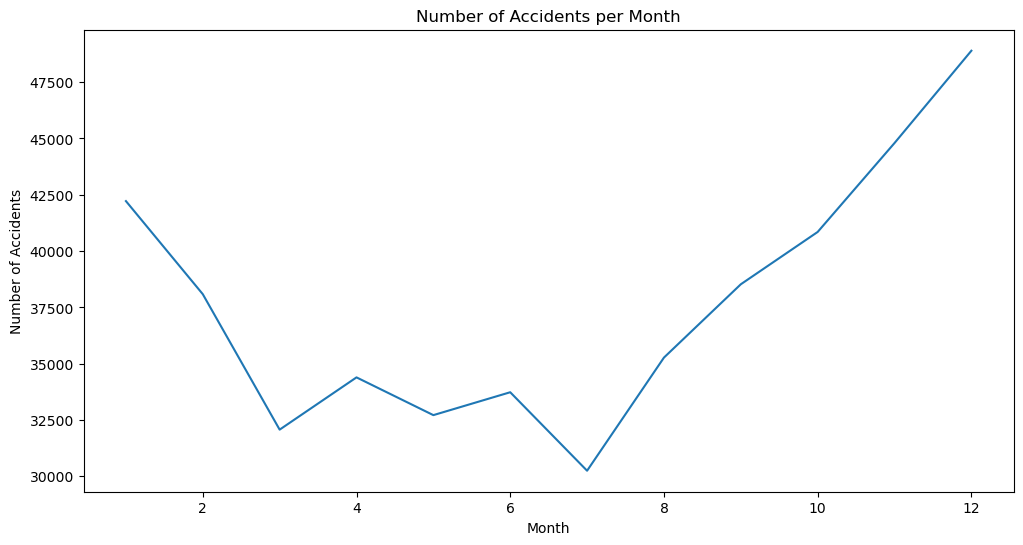

In [19]:
#Catching the accidents per month and plotting it into a graph.

df_copy_date['Month'] = df_copy_date['Start_Time'].dt.month

monthly_counts = df_copy_date['Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_counts.plot()
plt.title('Number of Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()

* Looking at the monthly data, we observe an increase in the number of accidents starting from the second semester, with an even higher peak towards the end of the year. There is also a decrease during the summer, when people tend to use their vehicles less for daily commutes, such as going to work.

* Another conclusion we can draw from this pattern is that there may be seasonal factors influencing the frequency of accidents. For example, during the colder months, adverse weather conditions such as rain or snow could contribute to an increase in accidents. Conversely, during the summer months, people may be more inclined to travel for vacations, leading to a decrease in accidents locally.

### Question 2: What are the locations with the most accidents?


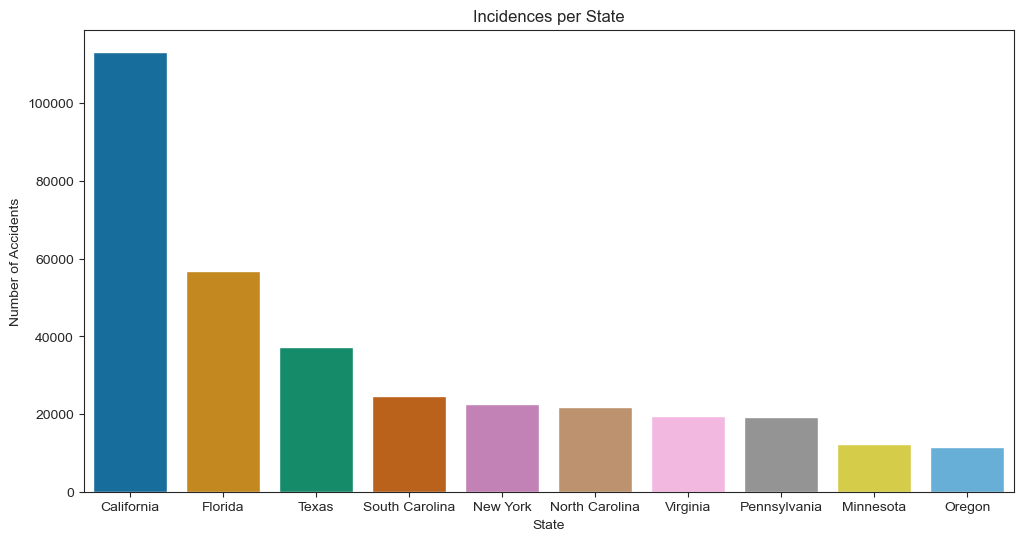

In [20]:
state_counts = df_updated['State_Name'].value_counts().head(10)

sns.set_style('ticks')
sns.set_palette('colorblind')

plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='colorblind')
plt.title('Incidences per State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.show()

* This suggests that states like California, Florida, and Texas have the highest incidence of accidents.

* This pattern could indicate various factors contributing to higher accident rates in these states, such as higher population densities, more traffic congestion, different driving cultures or behaviors, or varying road infrastructure conditions.

### Question 3: Wich features are most prevalent in accidents?

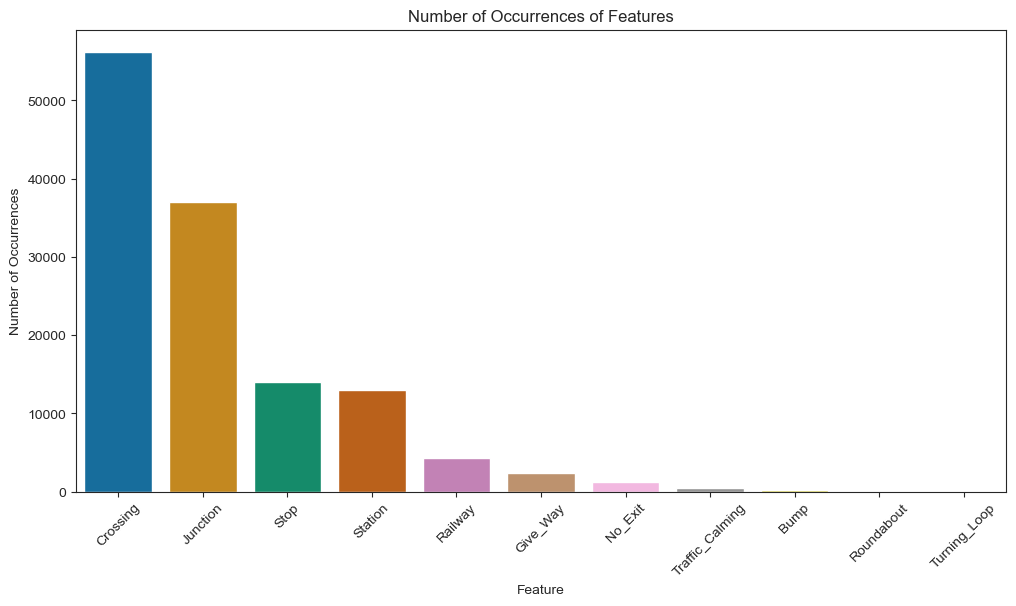

In [21]:
counts = df_updated[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                     'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                     'Turning_Loop']].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=counts.index, y=counts.values, palette='colorblind')
plt.title('Number of Occurrences of Features')
plt.xlabel('Feature')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

* Features like crossing, junction, stop, and station are the most recurrent because they are often associated with locations where complex interactions between vehicles occur, such as intersections (crossing) and junctions (junction), places where vehicles must stop (stop), or passenger boarding and alighting locations (station). Therefore, it's natural for these features to have a high incidence in accidents due to the increased likelihood of conflicts and interactions between vehicles.

### Question 4: Is it possible to create a machine learning model capable of predicting accident severity based on features like duration and other characteristics? 

#### Correlation between Severity and Features

In [22]:
df_corr = df_updated[['Severity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Turning_Loop']]
df_corr.head()

,Severity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Turning_Loop
0,2,False,False,False,False,False,False,False,False,False,False,False
1,2,False,False,False,False,False,False,False,False,False,False,False
2,2,False,False,False,False,False,False,False,False,False,False,False
3,2,False,False,False,False,False,False,False,False,False,False,False
4,2,False,False,False,False,False,False,False,False,False,False,False


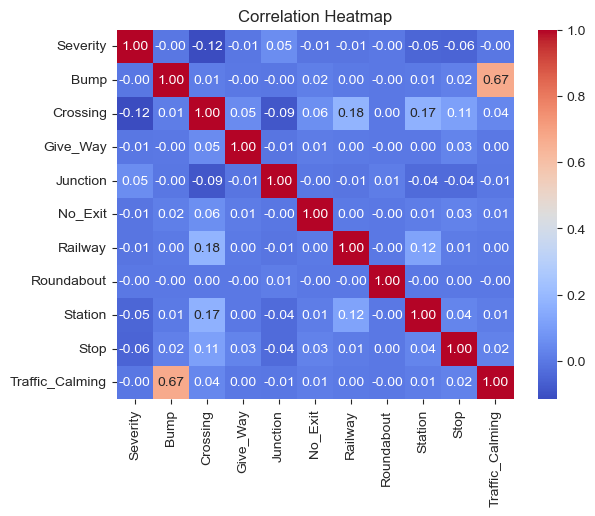

In [23]:
correlation = df_corr.drop(columns=['Turning_Loop']).corr(method='spearman')

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


* Characteristics such as 'Crossing', 'Junction', 'Station', and 'Stop' have moderately negative correlations witha severity, which may indicate that occurrences with these features are associated with less severe accidents.

* Characteristics such as 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Roundabout', and 'Traffic_Calming' have very weak correlations with severity. This might suggest that these features may not have a significant impact on accident severity.

* Overall, while some features show modest correlations with severity, it's important to remember that correlation does not imply causality. Further analysis and modeling are needed to understand the precise relationship between these features and accident severity.



#### Preparing the data for XGBClassifier model creation to predict severity based on certain circumstances.

In [24]:
#Converting date columns to datetime to obtain accident duration

df_copy_date2 = df_updated.copy()

df_copy_date2['Start_Time'] = pd.to_datetime(df_copy_date2['Start_Time'], format='ISO8601')
df_copy_date2['End_Time'] = pd.to_datetime(df_copy_date2['End_Time'], format='ISO8601')

df_copy_date2['Duration'] = df_copy_date2['End_Time'] - df_copy_date2['Start_Time']

df_copy_date2.head(2)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name,Duration
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,True,False,Louisiana,0 days 00:45:02
1,A-4694324,Source1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,Virginia,0 days 02:19:39


In [25]:
#Function to convert duration to seconds

def convert_to_seconds(duration):
    return duration.total_seconds()

df_copy_date2['Duration'] = df_copy_date2['Duration'].apply(convert_to_seconds)

df_copy_date2.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,State,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,State_Name,Duration
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,LA,...,False,False,False,False,False,False,True,False,Louisiana,2702.0
1,A-4694324,Source1,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,VA,...,False,False,False,False,False,False,False,False,Virginia,8379.0
2,A-5006183,Source1,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,Accident on W Central Ave from Floradale Ave t...,Lompoc,CA,...,False,False,False,False,False,False,True,False,California,7785.0
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Incident on I-90 EB near REST AREA Drive with ...,Austin,MN,...,False,False,False,False,False,False,False,False,Minnesota,7219.0
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,CA,...,False,False,False,False,False,False,False,False,California,8829.0


### XGBoost Classifier Model with Regularization


In [26]:
X = df_copy_date2[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Turning_Loop', 'Duration']]
y = df_copy_date2['Severity'] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model =  XGBClassifier(random_start=42,
                       reg_alpha=0.1,
                       reg_lambda=0.1)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Model Accuracy: {accuracy}")

print(classification_report(y_test, predictions))

Model Accuracy: 0.7986519460778431
              precision    recall  f1-score   support

           0       0.78      0.01      0.02       832
           1       0.82      0.97      0.89     79519
           2       0.52      0.17      0.25     17070
           3       0.38      0.00      0.00      2575

    accuracy                           0.80     99996
   macro avg       0.62      0.29      0.29     99996
weighted avg       0.75      0.80      0.75     99996



### Plotting the model values on graph

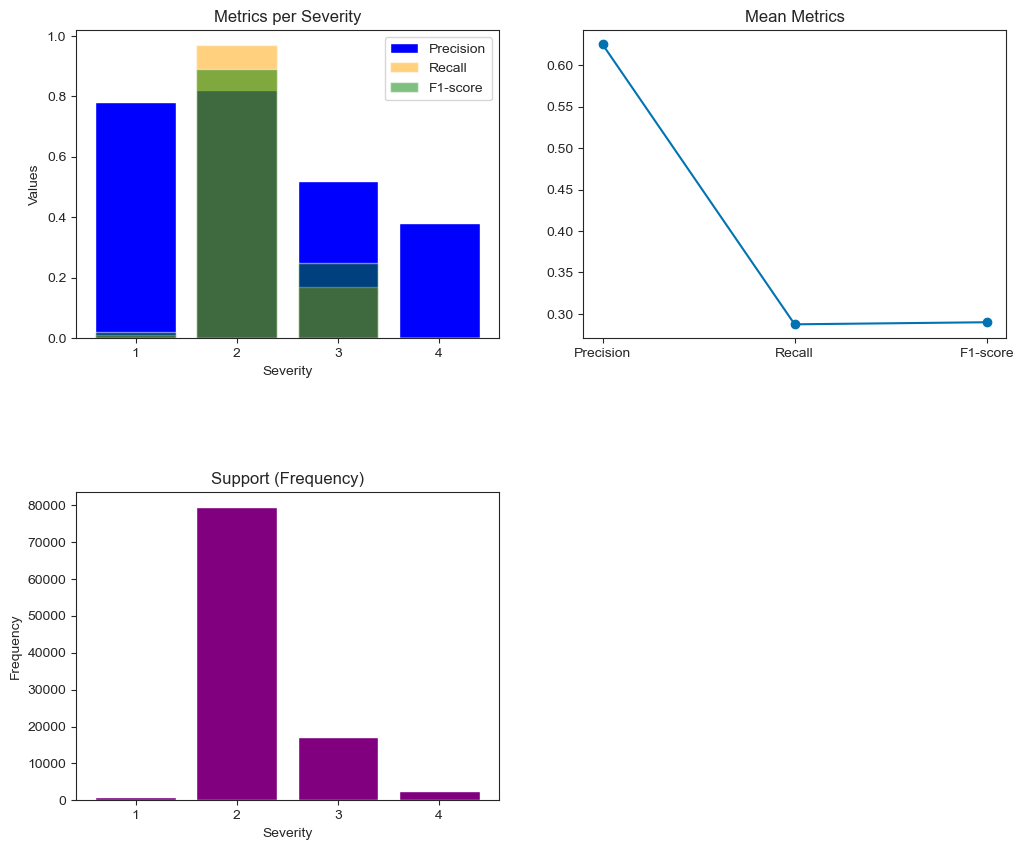

In [29]:
precision = [0.78, 0.82, 0.52, 0.38]
recall = [0.01, 0.97, 0.17, 0.00]
f1_score = [0.02, 0.89, 0.25, 0.00]
support = [832, 79519, 17070, 2575]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

severity = ['1', '2', '3', '4']
axs[0, 0].bar(severity, precision, color='blue', label='Precision')
axs[0, 0].bar(severity, recall, color='orange', label='Recall', alpha=0.5)
axs[0, 0].bar(severity, f1_score, color='green', label='F1-score', alpha=0.5)
axs[0, 0].set_title('Metrics per Severity')
axs[0, 0].set_xlabel('Severity')
axs[0, 0].set_ylabel('Values')
axs[0, 0].legend()

mean_metrics = [np.mean(precision), np.mean(recall), np.mean(f1_score)]
axs[0, 1].plot(['Precision', 'Recall', 'F1-score'], mean_metrics, marker='o')
axs[0, 1].set_title('Mean Metrics')

axs[1, 0].bar(severity, support, color='purple')
axs[1, 0].set_title('Support (Frequency)')
axs[1, 0].set_xlabel('Severity')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].axis('off')

plt.subplots_adjust(hspace=0.5)

plt.show()


## XGBClassifier Model Evaluation

* The XGBClassifier model has demonstrated remarkable accuracy in predicting accident severity, with an overall accuracy of approximately 80%. However, upon closer examination of precision, recall, and F1-score metrics for each severity class, we observe varying results.

* It is noteworthy that the model achieved an 82% precision in identifying severity grade 2 accidents, but showed significantly lower performance in predicting other classes, with a precision of only 38% for severity grade 4 accidents.

* It is important to emphasize that while the model's precision is high in some classes, the recall is low for others, indicating a difficulty in correctly identifying cases in these classes.

* These results suggest the need for further analysis of class imbalance in the dataset and potential adjustments to the model to improve generalization for all severity classes.


#### Severity Count in a pie chart

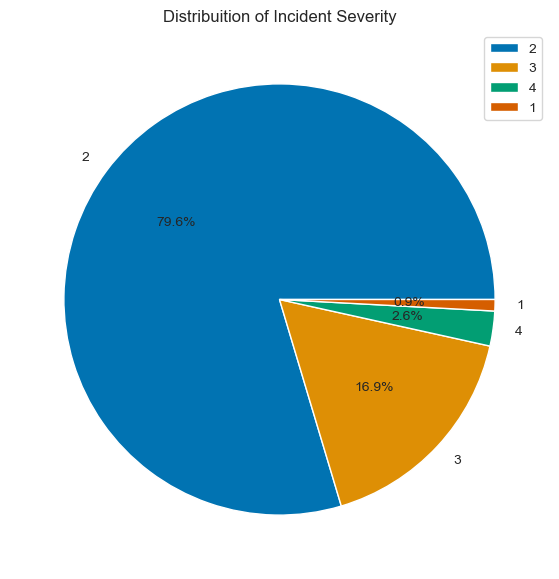

In [28]:
severity_count = df_copy_date2['Severity'].value_counts()

plt.figure(figsize=(10,7))
plt.pie(severity_count, labels=severity_count.index, autopct='%1.1f%%')
plt.legend()
plt.title('Distribuition of Incident Severity')
plt.show()


#### Conclusion:

* Accidents have been increasing every year, possibly due to the growth of the automotive industry.

* States with higher population density are more prone to have more accidents.

* Features like crossing, junction, and stop are present in the majority of accidents.

* It's possible to create a machine learning model to predict the severity of accidents, but it's not entirely accurate.

* Open to feedback and criticism.